<a href="https://colab.research.google.com/github/tcotte/CNN_Pytorch/blob/master/tp_mnist_CNN_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST: convolution network



In [1]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

if cuda:
    torch.cuda.manual_seed(SEED)

In [2]:

# normalize will center around -1 1
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) #Normalisation pour MIST
train = MNIST('./data', train=True, download=True, transform=trans, )
test = MNIST('./data', train=False, download=True, transform=trans, )


print (train)
# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Two CNN + two FC Layers NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # use nn.Sequential() for each layer1 and layer2, with nn.Conv2d + nn.ReLU + nn.MaxPool2d
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels =1, out_channels =3, kernel_size=(2,2)), # output dimension = (28-2+1)*27*3= 2187
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=1) # output dimension = (27-2+1)*26*3 = 
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels =3, out_channels =9, kernel_size=(2,2)), # output dimension = (26-2+1)*25*9
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=1) #output dimension = (25-2+1)*24*9 = 5184
        )
        # use nn.Linear with 1000 neurons
        self.fc1 = nn.Linear(5184, 1000)
        # use nn.Linear to output a one hot vector to encode the output
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # use reshape() to match the input of the FC layer1
        out = out.reshape(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        # use F.log_softmax() to normalize the output
        sm = nn.functional.log_softmax(out, _stacklevel=3) #?stacklevel
        return sm    

# Another model inspired from LeNet
class Model_Type_LeNet(nn.Module):
    def __init__(self):
        super(Model_Type_LeNet, self).__init__()
        # use nn.Sequential() for each layer1 and layer2, with nn.Conv2d + nn.ReLU + nn.MaxPool2d
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels =1, out_channels =6, kernel_size=(5,5)), # output dimension = (28-5+1)*24*6= 2187
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2) # output dimension = ((24-2)%2+1)*12*6 = 
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels =6, out_channels =16, kernel_size=(5,5)), # output dimension = (12-5+1)*8*16
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2) #output dimension = ((8-2)%2+1)*4*16 = 256
        )
        # use nn.Linear with 1000 neurons
        self.fc1 = nn.Linear(256, 1000)
        # use nn.Linear to output a one hot vector to encode the output
        self.fc2 = nn.Linear(1000, 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # print(out.size())
        # use reshape() to match the input of the FC layer1
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        # use F.log_softmax() to normalize the output
        sm = nn.functional.log_softmax(out, _stacklevel=3)
        return sm
    


In [5]:
    
model = Model() #Model_Type_LeNet() # model type LeNet is not good for this applciation. Maybe it's because of the dimensions of the input picture or the MaxPool2d instead of the MeanPool2D

model.to(device)
# use an optim.Adam() optimizer
optimizer = optim.Adam(model.parameters(),  lr=0.001) #test with different values

In [6]:
EPOCHS = 5
losses = []
ave_grads = dict()

for n, p in model.named_parameters():
  if(p.requires_grad) and ("biais" not in n): 
    ave_grads[n] = []

# Eval
evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
evaluate_y = test_loader.dataset.targets
evaluate_x = evaluate_x.unsqueeze_(1)

evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)
train_size = len(train_loader.dataset)
batch_size = (train_size / 256) if (cuda) else  (train_size / 64)

for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = data.to(device), target.to(device)

        #for params in model.parameters(): 
          #print(params, " : ", torch.mean(params))
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 
         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')
            
    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.124696	 Test Accuracy: 69.2000%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.179463	 Test Accuracy: 69.7300%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.026075	 Test Accuracy: 76.7100%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.048853	 Test Accuracy: 80.4200%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.128847	 Test Accuracy: 84.7700%


(0.0, 1.0)

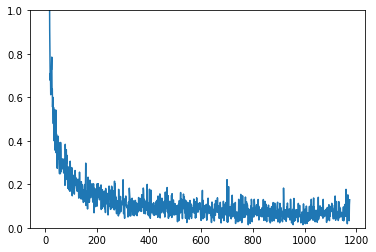

In [7]:
# plot the losses
import matplotlib.pyplot as plt

plt.plot(losses)
plt.ylim(0,1)

In [8]:
# plot the accuracy for each epoch and verify if there is overfitting
model.eval()
output = model(evaluate_x)

pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().item()/d.size()[0]

print('Accuracy:', accuracy*100, '%')

Accuracy: 84.77 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


<generator object Module.modules at 0x7faf96397150>


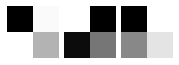

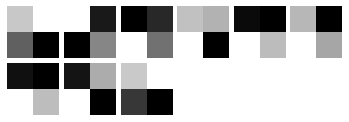

In [9]:
# display the learned convolution weights as 2D image
def plot_kernels(tensor, num_cols=6):
    # print(tensor)
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0], cmap='Greys')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

print(model.modules())
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        # find the weight tensor for each module...
        plot_kernels(m.weight.data.cpu().numpy()) # .data.cpu().numpy() -> transfer data from gpu to cpu to use kernel

In [10]:
# https://github.com/alwynmathew/gradflow-check/blob/master/gradflow_check.py
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

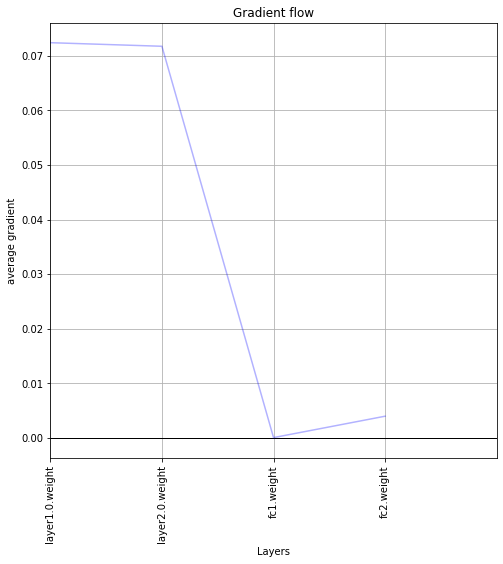

In [11]:
# plot the average of the gradient: need to track "ave_grads" during training after loss.backward()
layers = []
for n, p in model.named_parameters():
    if(p.requires_grad) and ("bias" not in n):
        layers.append(n)
fig = plt.figure(figsize=(8,8))
ax = fig.subplots()
plt.xlabel("mini batch")
plt.ylabel("Average Gradient")
plt.title("Gradient Flow")
plt.grid(True)

plot_grad_flow(model.named_parameters())

# ave_grads = ave_grads.view(len(layers),-1)
# for i in range(len(layers)):
#   ax.plot(ave_grads[i,:], label=layers[i])
# plt.legend()
# plt.show()